In [1]:
import matplotlib.pyplot as plt
import numpy as np

from numpy.typing import NDArray

from karabo.imaging.image import Image
from karabo.imaging.imager_rascil import (
    RascilDirtyImager,
    RascilDirtyImagerConfig,
)
from karabo.imaging.imager_wsclean import (
    WscleanImageCleaner,
    WscleanImageCleanerConfig,
)
from karabo.imaging.util import project_sky_to_image
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import (
    PyBDSFSourceDetectionResult,
)
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

from karabo.simulation.sample_simulation import run_sample_simulation

# Render plots inline
%matplotlib inline

### Simulate visibilities

In [2]:
visibility, phase_center, sky, _, _, _ = run_sample_simulation(verbose=True)

Getting Sky Survey
Filtering Sky Model
Setting Up Telescope
Setting Up Observation
Generating Visibilities
Parameter 'use_gpus' is None! Using function 'karabo.util.gpu_util.is_cuda_available()'. To overwrite, set 'use_gpus' True or False.
Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-7DTBlwzfJO for interferometer disk-cache.
Matched path /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-7DTBlwzfJO/measurements.MS to format MS
Saved visibility to /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-7DTBlwzfJO/measurements.MS


### Imaging

Generate a dirty image and a cleaned image to showcase the source detection capabilities. For more examples on imaging, see the imaging.ipynb example notebook.

In [3]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/Imager-Dirty-7d1RXjr9x7 for disk-cache for dirty.fits


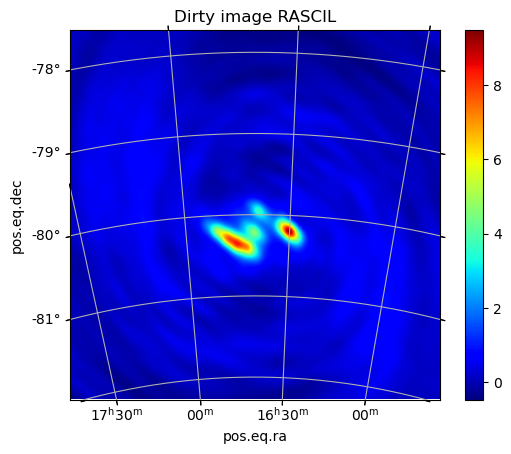

In [4]:
dirty_image = RascilDirtyImager(
    RascilDirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_dirty_image(visibility)
dirty_image.plot(title="Dirty image RASCIL")

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-cleaned-9ThLab6zBO for Disk cache for WSClean cleaned images
WSClean command: [cd /tmp/karabo-STM-michel-dVM6tqMIQ3/WSClean-cleaned-9ThLab6zBO && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -auto-threshold 3 /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-7DTBlwzfJO/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-michel-dVM6tqMIQ3/interferometer-7DTBlwzfJO/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%.

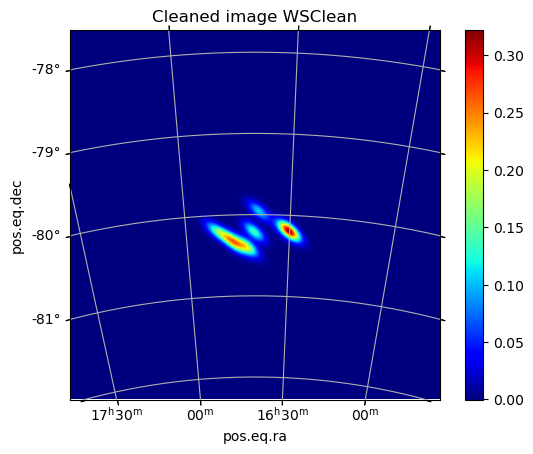

In [5]:
cleaned_image = WscleanImageCleaner(
    WscleanImageCleanerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_cleaned_image(visibility)
cleaned_image.plot(title="Cleaned image WSClean")

### Source Detection

Get ground truth coordinates of sources

In [6]:
ground_truth, sky_idxs = project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)

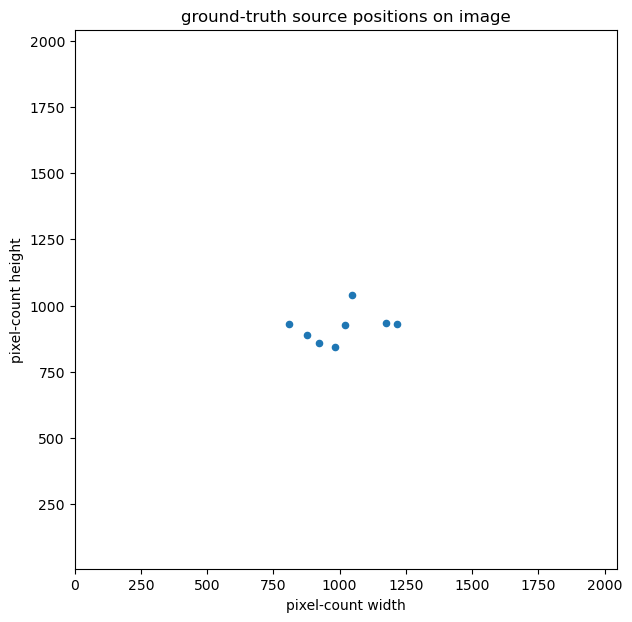

In [7]:
fig, ax = plt.subplots(
    figsize=(7, 7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title("ground-truth source positions on image")
plt.xlim((0, imaging_npixel))
plt.ylim((0, imaging_npixel))
plt.xlabel("pixel-count width")
plt.ylabel("pixel-count height")
plt.show()

In [8]:
def detect_sources_and_evaluate(
    image: Image,
    ground_truth: NDArray[np.float64],
    sky: SkyModel,
    sky_idxs: NDArray[np.int64],
) -> SourceDetectionEvaluation:
    detection_result = PyBDSFSourceDetectionResult.detect_sources_in_image(
        image=image,
        thresh_isl=15,
        thresh_pix=20,
    )

    assignments = (
        SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
            ground_truth=ground_truth.T,
            detected=detection_result.get_pixel_position_of_sources(),
            max_dist=10,
            top_k=3,
        )
    )
    print(assignments)

    sde = SourceDetectionEvaluation(
        sky=sky,
        ground_truth=ground_truth,
        assignments=assignments,
        sky_idxs=sky_idxs,
        source_detection=detection_result,
    )
    sde.plot()

    sde.plot_confusion_matrix()

    return sde

Run source detection on dirty image and evaluate outcome

/home/michel/karabo/Karabo-Pipeline/karabo/sourcedetection/result.py:170: KaraboWarning: No beam parameter provided by `beam` or found in image header. guessing parameters using `Imager.guess_beam_parameters`.
  warn(


Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-9FlkevCn34 for pybdsf source-detection-result disk-cache
--> Wrote ASCII file '/tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-9FlkevCn34/sources.csv'
--> Wrote file '/tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-9FlkevCn34/ch0-result.fits'
[[ 0.         -1.                 inf]
 [ 1.         -1.                 inf]
 [ 2.         -1.                 inf]
 [ 3.          0.          3.90722295]
 [ 4.         -1.                 inf]
 [ 5.         -1.                 inf]
 [ 6.         -1.                 inf]
 [ 7.         -1.                 inf]]


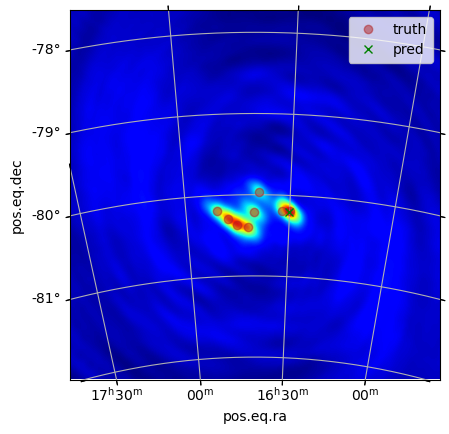

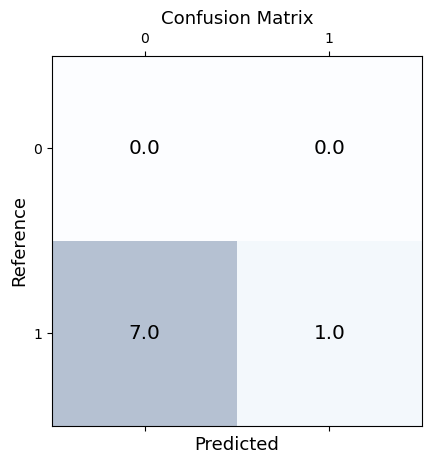

In [9]:
sde_dirty = detect_sources_and_evaluate(
    image=dirty_image, ground_truth=ground_truth, sky=sky, sky_idxs=sky_idxs
)

Source detection on dirty image correctly found one source and missed the other seven.

Run source detection on clean image and evaluate outcome

Creating /tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-TTuK5Kk8My for pybdsf source-detection-result disk-cache
--> Wrote ASCII file '/tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-TTuK5Kk8My/sources.csv'
--> Wrote file '/tmp/karabo-STM-michel-dVM6tqMIQ3/pybdsf-sdr-TTuK5Kk8My/ch0-result.fits'
[[-1.          8.                 inf]
 [ 0.          4.          1.39768156]
 [ 1.          7.          5.33529861]
 [ 2.          1.          3.49205253]
 [ 3.          0.          1.39546873]
 [ 4.          2.          1.40429463]
 [ 5.          6.          6.84999665]
 [ 6.          5.          2.34801502]
 [ 7.          3.          1.40031225]]


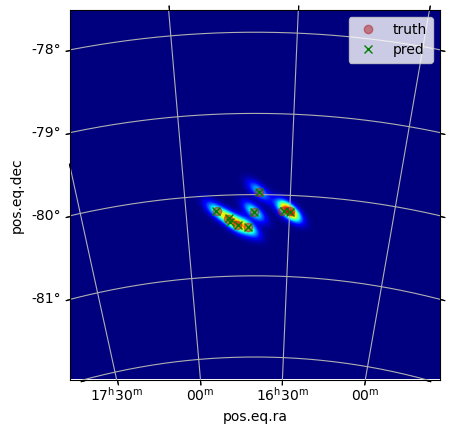

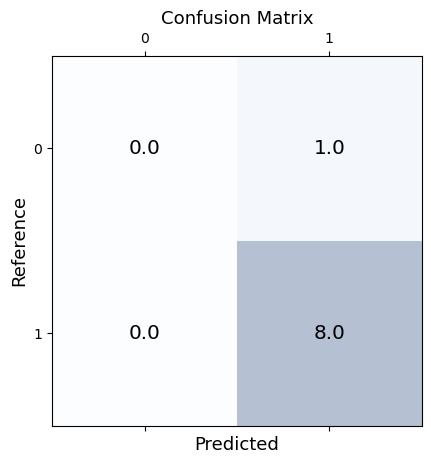

In [10]:
sde_cleaned = detect_sources_and_evaluate(
    image=cleaned_image, ground_truth=ground_truth, sky=sky, sky_idxs=sky_idxs
)

Source detection on cleaned image correctly found all of the eight sources.

#### Additional plots

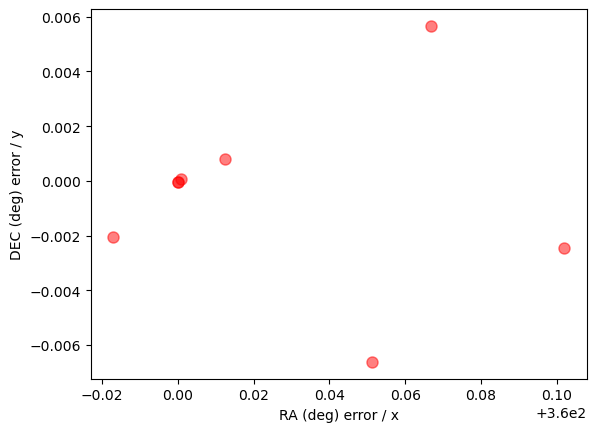

In [11]:
# Plot error ra and dec
sde_cleaned.plot_error_ra_dec()

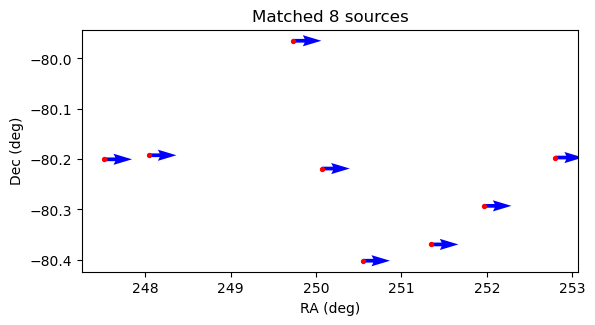

In [12]:
sde_cleaned.plot_quiver_positions()

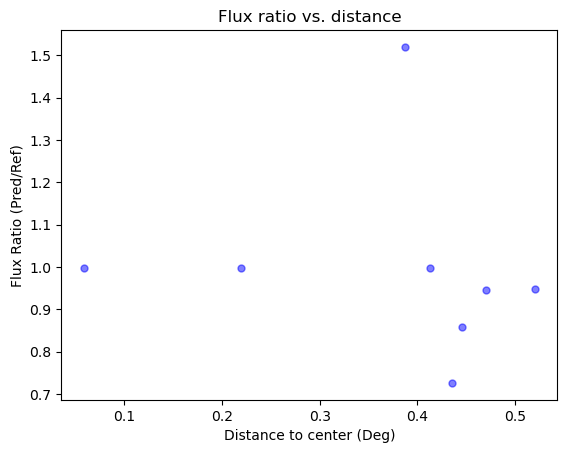

In [13]:
sde_cleaned.plot_flux_ratio_to_distance()

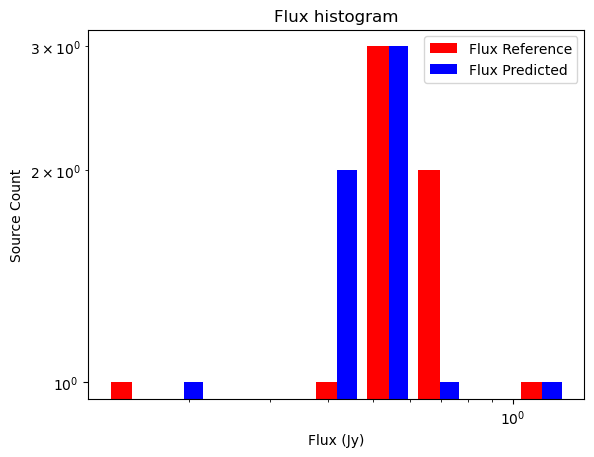

In [14]:
sde_cleaned.plot_flux_histogram()

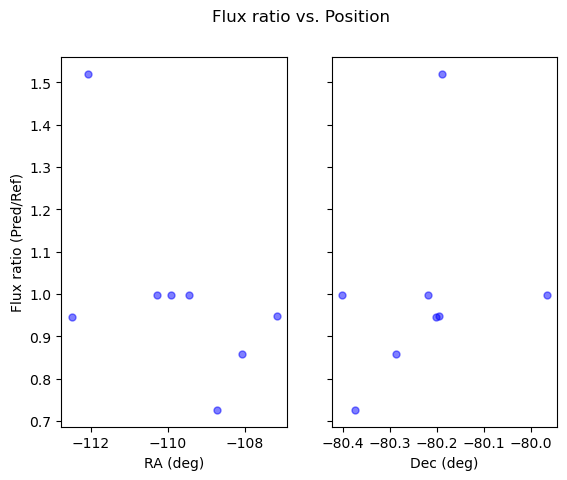

In [15]:
sde_cleaned.plot_flux_ratio_to_ra_dec()